In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


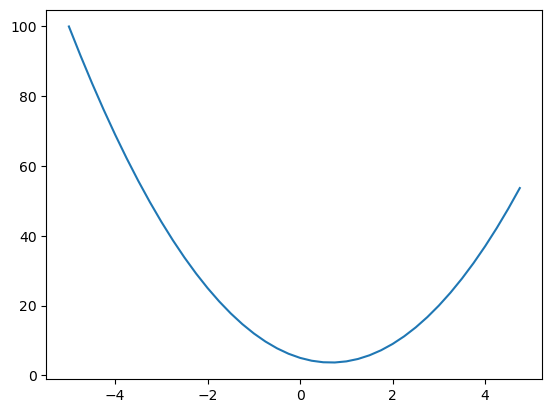

In [5]:
xs = np.arange(-5, 5, 0.25)
print(xs)
ys = f(xs)
plt.plot(xs, ys)

In [13]:
h = 0.0000000000001
x = 3.0
(f(x+h)-f(x))/h

13.997691894473974

In [14]:
x = -3
(f(x+h)-f(x))/h

-22.026824808563106

In [15]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [17]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [18]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h 
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [19]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
b += h 
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [229]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += out.grad*other.data
            other.grad += out.grad*self.data
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self*other

    def __radd__(self, other):
        return self+other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += out.grad*(1-t**2)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.grad*out.data
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int or float as power"
        out = Value(self.data **other, (self,), f'**{other}')
        def _backward():
            self.grad += out.grad * other * (self.data **(other-1))
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
        
    def __sub__(self, other):
        return self + (other*-1)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [68]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [64]:
c._op

''

In [71]:
# visualization code
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

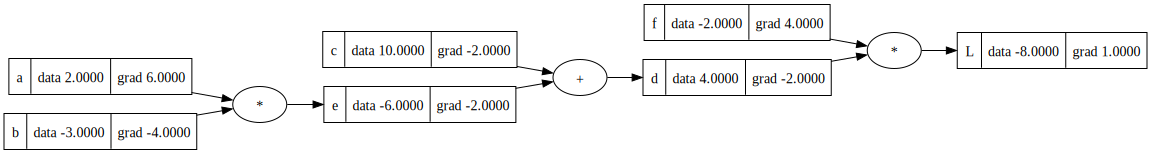

In [95]:
draw_dot(L)

In [100]:
def lol():
    h = 0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0+h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f ; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [101]:
lol()

-3.9999999999995595


In [88]:
L.grad = 1
f.grad = 4.0
d.grad = -2.0

d = c+e
#KNOW
dl/dd
#WANT
dl/dc and dl/de
dl/dc = dl/dd*dd/dc = dl/dd
dl/de = dl/dd*dd/de = dl/dd

In [91]:
c.grad = -2.0
e.grad = -2.0

In [ ]:
e = a*b
#KNOW
dl/de = -2.0
#WANR
dl/da and dl/db
dl/da = dl/de*de/da = dl/de*b
dl/db = dl/de*de/db = dl/de*a

In [94]:
a.grad = -2.0*-3
b.grad = -2.0*2

In [103]:
# Lets nudge our inouts for L to go up
# go in the direction of gradient

a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b;
d = e+c;
f = Value(-2.0)
L = d*f

In [104]:
print(L)

Value(data=-6.860800000000001)


In [ ]:
# Lets backpropagate through a neural network!!!


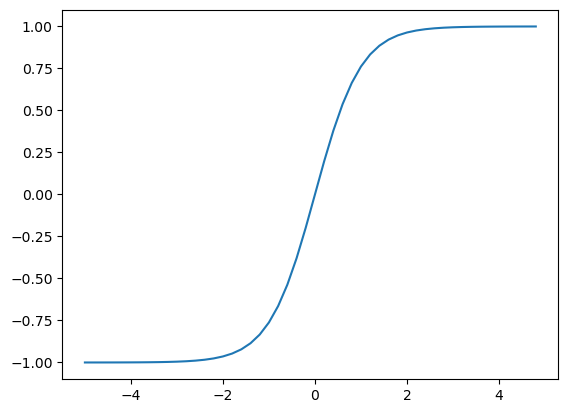

In [105]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

In [179]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.88131, label='b')
#x1w1 +x2w2+b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o'


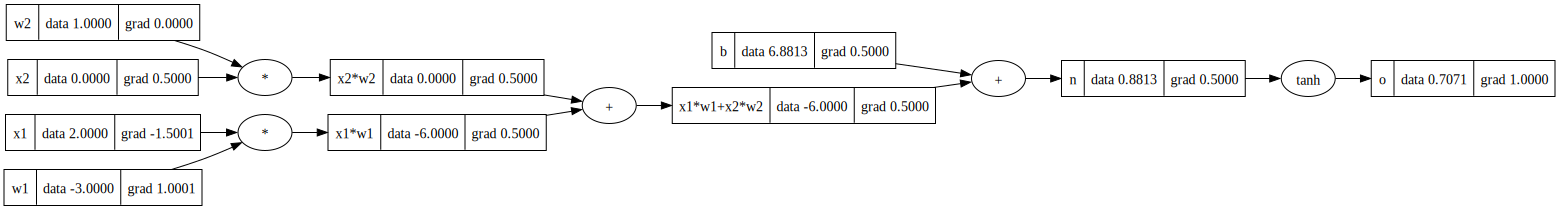

In [182]:
draw_dot(o)

In [126]:
# Calculating gradients manually
o.grad = 1.0
n.grad = 1-0.7071**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x1.grad = x1w1.grad*w1.data
w1.grad = x1w1.grad*x1.data
x2.grad = x2w2.grad*w2.data
w2.grad = x2w2.grad*x2.data

In [143]:
# Instead of calling gradients manually, using the backward function.
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.88131),
 Value(data=0.88131),
 Value(data=0.707074986247229)]

In [176]:
# Call backwards using topo in reverse order
o.grad = 1.0
# We need not call backward on each node. Instead, lets do topological sort, and then call backward
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

In [181]:
# call backwards on o
o.backward()

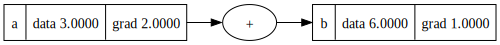

In [184]:
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

In [218]:
a = Value(2.0, label='a')
2*a
a+2
2+a

Value(data=4.0)

In [221]:
b = Value(4.0, label='b')
a / b
a - b

Value(data=-2.0)

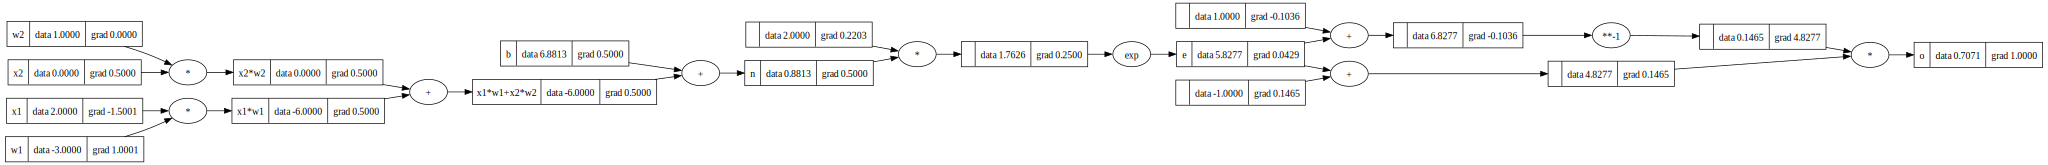

In [230]:
# We have implemented all the sub components of tanh so lets break it up
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.88131, label='b')
#x1w1 +x2w2+b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1+x2*w2'
n = x1w1x2w2+b;n.label='n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)


In [238]:
# Now lets do all this using Pytorch
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88131]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7070749793038555
----
x2 0.5000449736424523
w2 0.0
x1 -1.5001349209273567
w1 1.0000899472849045


In [235]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [241]:
x2.data, x2.grad

(tensor([0.], dtype=torch.float64), tensor([0.5000], dtype=torch.float64))

In [326]:
import random

class Neuron:
    def __init__(self, nin):
        #random.seed(10)
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        #random.seed(10)
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        act = np.dot(self.w, x) + self.b
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        print(sz)
        print(len(nouts))
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            


In [280]:
print(l.neurons)

[<__main__.Neuron object at 0x167038fd0>, <__main__.Neuron object at 0x16702a380>, <__main__.Neuron object at 0x16705b700>]


In [282]:
n = Neuron(3)
n([1.0, 2.0, 3.0])

Value(data=0.9544785501053973)

In [286]:
x = [2.0, 3.0, 1.0]
l = Layer(3,4)
l(x)

[Value(data=-0.020953848061388915),
 Value(data=-0.9806131749738246),
 Value(data=-0.5550594129837405),
 Value(data=-0.84129489843115)]

In [327]:
mlp = MLP(3, [4,4,1])
mlp(x)

[3, 4, 4, 1]
3


Value(data=-0.6577381942201428)

In [330]:
mlp.parameters()

[Value(data=0.1413797212097303),
 Value(data=0.7985663989907847),
 Value(data=-0.8300291982070465),
 Value(data=0.888679759441424),
 Value(data=0.5061813802565776),
 Value(data=0.7017868828290381),
 Value(data=0.6304275128356029),
 Value(data=-0.21239598249495595),
 Value(data=-0.9536174469612546),
 Value(data=0.9950690486844325),
 Value(data=0.2658112282774363),
 Value(data=0.4233549608752696),
 Value(data=0.3912778708280751),
 Value(data=-0.40249971208128854),
 Value(data=0.3138100229979188),
 Value(data=-0.09847886612143464),
 Value(data=-0.5464306552359768),
 Value(data=-0.0009260688355028357),
 Value(data=-0.06449423129051879),
 Value(data=-0.3961371485461138),
 Value(data=0.49887760804836034),
 Value(data=0.8177892334486112),
 Value(data=0.1961023622708291),
 Value(data=-0.953608699131204),
 Value(data=0.08888890396931726),
 Value(data=0.26172488488095125),
 Value(data=0.6309866676327021),
 Value(data=-0.393140596393706),
 Value(data=-0.5311994072340367),
 Value(data=-0.252507930

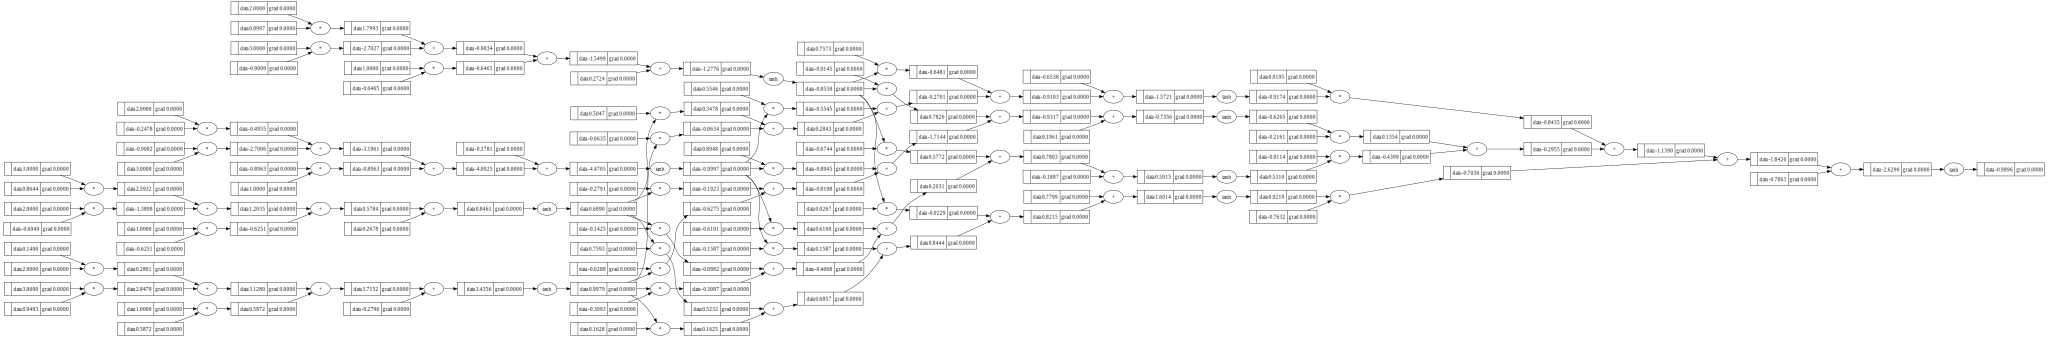

In [297]:
draw_dot(mlp(x))

In [347]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
mlp = MLP(3, [4,4,1])
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[3, 4, 4, 1]
3


[Value(data=-0.7834257595651957),
 Value(data=-0.7290100708057659),
 Value(data=-0.6328530908503824),
 Value(data=-0.754590355869041)]

In [348]:
loss = sum((ypred-ygt)**2 for ygt, ypred in zip(ys, ypred))
loss

Value(data=6.467427151412156)

In [388]:
ypred = [mlp(x) for x in xs]
loss = sum((ypred-ygt)**2 for ygt, ypred in zip(ys, ypred))
loss

Value(data=1.2113153639134626)

In [386]:
loss.backward()

In [387]:
for p in mlp.parameters():
    p.data += -0.1*p.grad

In [389]:
ypred

[Value(data=0.99997959812702),
 Value(data=-0.9744831340427552),
 Value(data=0.10030189102163431),
 Value(data=0.9999592181157548)]

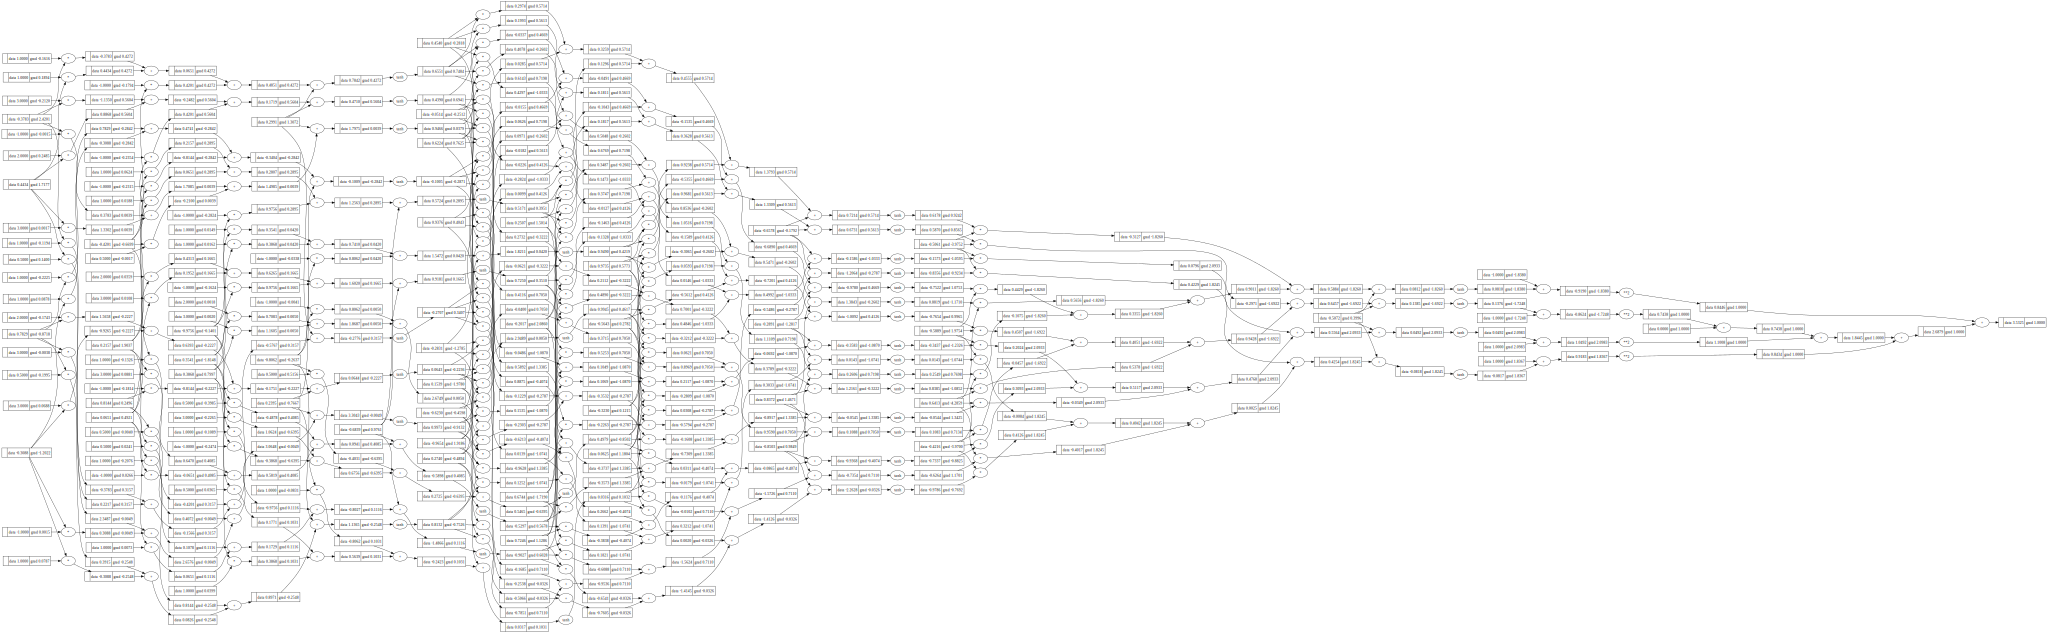

In [303]:
draw_dot(loss)

In [310]:
mlp.layers[0].neurons[0].b.grad

1.3072455543703345

In [394]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
mlp = MLP(3, [4,4,1])
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[3, 4, 4, 1]
3


[Value(data=0.037235327305241296),
 Value(data=-0.1439837573996444),
 Value(data=0.14563102670106967),
 Value(data=-0.517125039176559)]

In [395]:
# lets write a training loop
for k in range(20):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((ypred-ygt)**2 for ygt, ypred in zip(ys, ypred))
    
    # backward pass
    # reset grad to 0
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -0.05*p.grad

    print(k, loss.data)

0 5.273818456421299
1 4.468030740560964
2 3.925671561367427
3 3.4630873130846664
4 3.096862391581242
5 2.799876356111388
6 2.5166930476223373
7 2.1950556174756906
8 1.797048116511775
9 1.3383025992012259
10 0.916499381102911
11 0.6174208931265166
12 0.4332323242991674
13 0.32102699666328816
14 0.24951497151094648
15 0.20138607439055223
16 0.1673693075060494
17 0.14232358205352352
18 0.12325314003279735
19 0.108325143427852


In [396]:
ypred

[Value(data=0.8152019814711199),
 Value(data=-0.9320212420484614),
 Value(data=-0.7770941086015009),
 Value(data=0.8590507615385655)]